In [106]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse

import rtmtools.clirad.sw.wrangle as cliradwrangle

import rtmtools.rrtmg.sw.wrangle as rrtmgwrangle

import climatools.offline_scripts.intermodel as scripts_intermodel



importlib.reload(aerutils)

importlib.reload(aeranalyse)

importlib.reload(cliradwrangle)

importlib.reload(rrtmgwrangle)

importlib.reload(scripts_intermodel)


<module 'climatools.offline_scripts.intermodel' from '/nuwa_cluster/home/jackyu/climatools/climatools/offline_scripts/intermodel.py'>

In [10]:
name_molecule = 'H2O' #r'$H_{2}O$'

In [4]:
# Load CRD results

# CRD H2008
#pathout_crd = os.path.join('/nuwa_cluster/home/jackyu',
#                           'radiation/crd/SW/examples',
#                           'mls75_H2O_new/OUTPUT_CRD.dat')
#pnl_crd = aerutils\
#.OUTPUT_RADSUM_to_pandasPanel(readfrom=pathout_crd, 
#                              signed_fluxes=True)

path_crd = '/nuwa_cluster/home/jackyu/radiation/crd/SW/examples/mls75_H2O_new/OUTPUT_CRD.dat'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom=path_crd, signed_fluxes=True)

In [5]:
# CRD H2012
pathout_crd = os.path.join('/nuwa_cluster/home/jackyu',
                           'radiation/crd/SW/examples',
                           'mls75_H2O_solzen_60_H2012/OUTPUT_CRD.dat')
pnl_crd_H2012 = aerutils\
.OUTPUT_RADSUM_to_pandasPanel(readfrom=pathout_crd, 
                              signed_fluxes=True)

In [6]:
# Load CLIRAD results
pathout_clirad = os.path.join('/nuwa_cluster/home/jackyu',
                              'radiation/clirad/SW/examples',
                              'mls75_H2O/OUTPUT_CLIRAD.dat')
pnl_clirad = cliradwrangle\
.OUTPUT_CLIRAD_to_PandasPanel(readfrom=pathout_clirad, 
                              signed_fluxes=True)

In [7]:
# Load AER RRTMG's results
pathout_rrtmg = os.path.join('/nuwa_cluster/home/jackyu',
                             'radiation/rrtmg/SW/examples',
                             'mls_71lvls_H2O/OUTPUT_RRTM')
pnl_rrtmg = rrtmgwrangle\
.OUTPUT_RRTM_to_pandasPanel(readfrom=pathout_rrtmg, 
                            signed_fluxes=True)

# 'Total' heating rates

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  629.330652  629.330652      0.460772
30   299.800000        0  620.060742  620.060742      0.989602
0   1013.000000        0  515.385629  515.385629      1.222242

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  629.330652  629.330652      0.461621
30   299.800000        0  619.993131  619.993131      0.997016
0   1013.000000        0  514.838220  514.838220      1.218964

RRTMG
      pressure   flux_up   flux_down    net_flux  heating_rate
70     0.00242 -0.000201  594.246285  594.246084       0.00000
30   299.70000 -0.000099  583.539690  583.539591       1.01312
0   1013.00000  0.000000  478.006790  478.006790       1.22063

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000234  682.424680  682.424446      1.135757
30   299.800000 -0.000089  671.945614  671.945525      0.990692
0   1013.000000  0.000

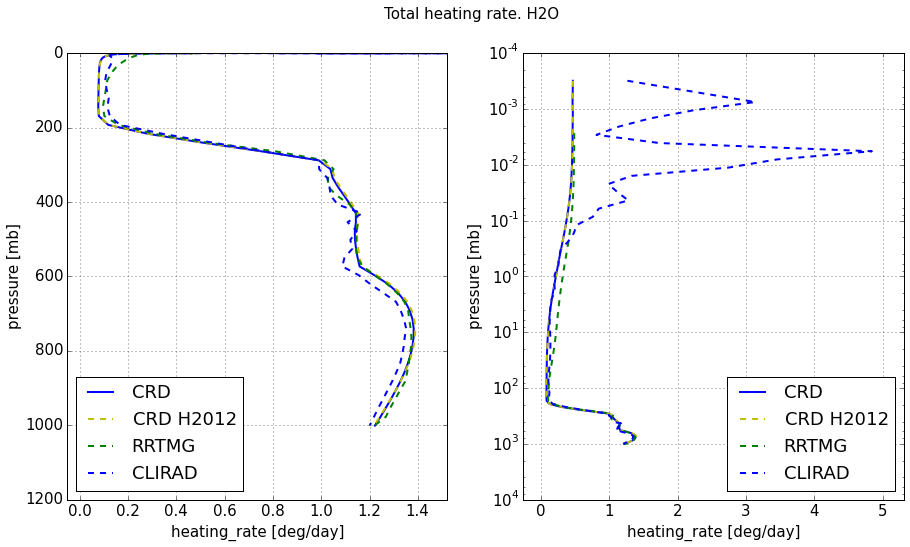

In [99]:
scripts_intermodel.sw_results_all_wavenumbers(
    infos_wavenumber = [('CRD', 'b', '-', pnl_crd),
                        ('CRD H2012', 'y', '--', pnl_crd_H2012),
                        ('RRTMG', 'g', '--', pnl_rrtmg)],
    infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)],
    name_molecule=name_molecule)

In [100]:
html_download = ('<a href="./shortwave_mls_{name_molecule}_total.xlsx"'
                 'download>shortwave_mls_{name_molecule}_total.xlsx</a>')

display.HTML(html_download.format(name_molecule=name_molecule))

# In selected spectral bands

In [ ]:
# By arbitrary bands

def define_spectral_bands():
    return [(1000, 4400),
           (4400, 8200),
           (8200, 14280),
           (14280, 25000),
           (1000, 25000)]


def fluxtableNhrplot_by_bands(bands, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
          
    pnls = [aeranalyse.lines2bands(pnl_lbl, wbands = bands)\
            for pnl_lbl in pnls_lbl]
    
    
    for item in bands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {} ~ {} cm-1'.format(*item))      
        
        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['heating_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Heating rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = False,
                              xlim_linear = None,
                              xlim_log = None)
    
        display.display(plt.gcf()); plt.close()

In [110]:
print('Flux tables and heating rates in various spectral bands')
print()
print()

#fluxtableNhrplot_by_bands(define_spectral_bands(), \
#                         ('CRD', 'b', '-', pnl_crd),
#                         ('CRD H2012', 'y', '--', pnl_crd_H2012))

Flux tables and heating rates in various spectral bands




# In RRMTG's wavenumber bands

Flux tables and heating rates in RRTMG spectral bands


RRTMG-SW spectral band. Band 1. 2600.0 ~ 3250.0 cm-1.

RRTMG
      pressure  flux_up  flux_down  net_flux  heating_rate
70     0.00242       -0   6.046375  6.046375       0.00000
30   299.70000       -0   5.914259  5.914259       0.01725
0   1013.00000       -0   2.878889  2.878889       0.03686

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.046375  6.046375      0.001371
30   299.800000        0   5.911887  5.911887      0.016949
0   1013.000000        0   2.861529  2.861529      0.034454

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.046375  6.046375      0.001371
30   299.800000        0   5.912104  5.912104      0.016923
0   1013.000000        0   2.861435  2.861435      0.034531

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     -0.001371
30 -0.100000       -0   

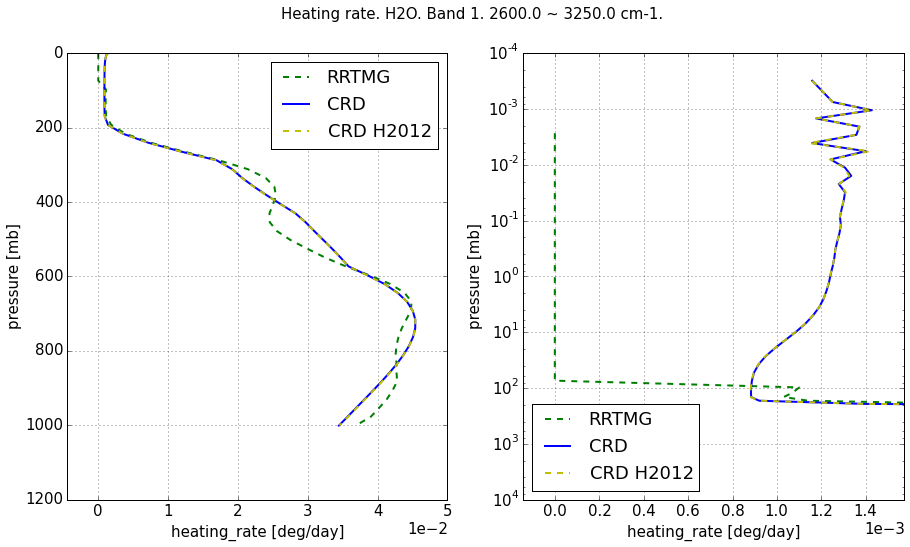


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 2. 3250.0 ~ 4000.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  10.192548  10.192548       0.00000
30   299.70000       -0   7.150149   7.150149       0.26814
0   1013.00000       -0   0.052051   0.052051       0.00878

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  10.192548  10.192548      0.274267
30   299.800000        0   7.202057   7.202057      0.270348
0   1013.000000        0   0.153976   0.153976      0.011476

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  10.192548  10.192548      0.274245
30   299.800000        0   7.203785   7.203785      0.270210
0   1013.000000        0   0.154372   0.154372      0.011493

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     -0.

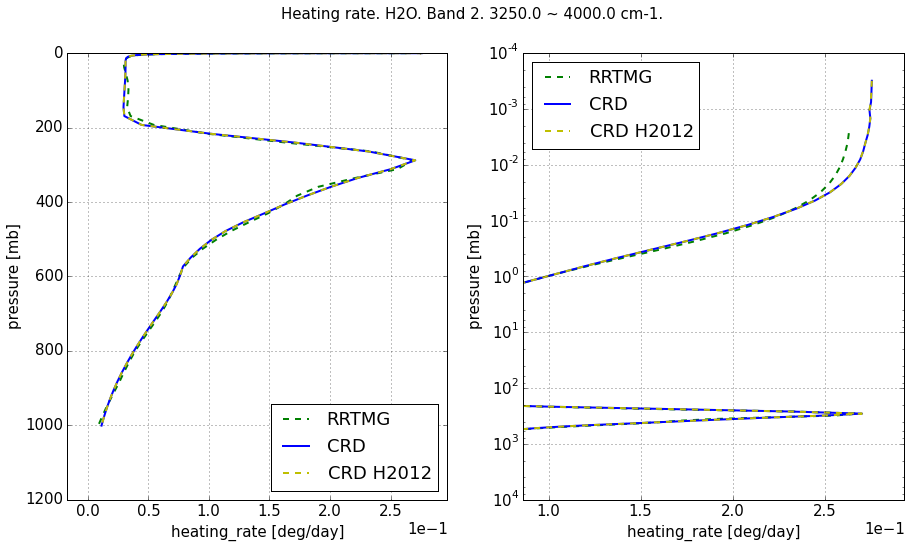


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 3. 4000.0 ~ 4650.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  11.837001  11.837001       0.00000
30   299.70000       -0  11.765769  11.765769       0.00925
0   1013.00000       -0   8.662882   8.662882       0.04323

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.837001  11.837001      0.000317
30   299.800000        0  11.774881  11.774881      0.008450
0   1013.000000        0   8.867141   8.867141      0.045376

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.837001  11.837001      0.000317
30   299.800000        0  11.774925  11.774925      0.008443
0   1013.000000        0   8.870176   8.870176      0.045389

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     -0.

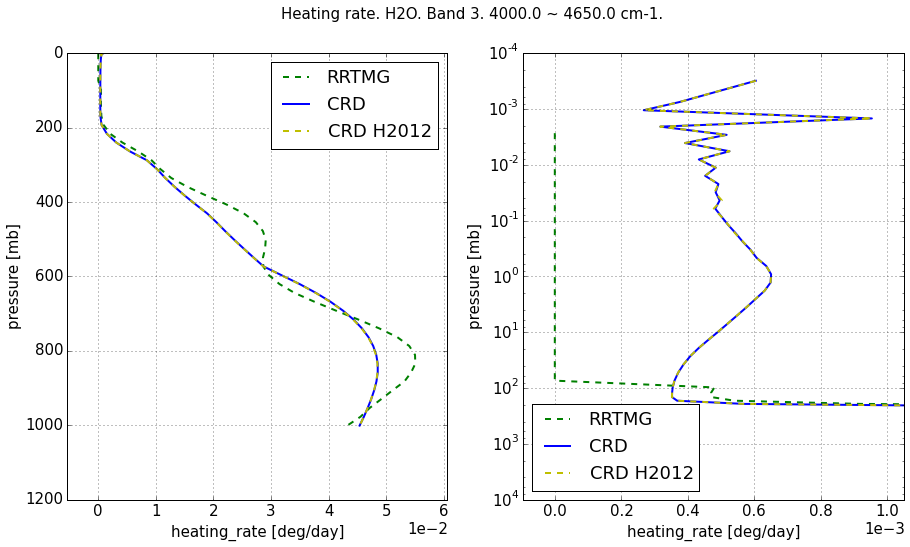


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 4. 4650.0 ~ 5150.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  11.175499  11.175499       0.00000
30   299.70000       -0  11.123278  11.123278       0.00813
0   1013.00000       -0   7.813123   7.813123       0.04522

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.175499  11.175499      0.000317
30   299.800000        0  11.121698  11.121698      0.008157
0   1013.000000        0   7.732939   7.732939      0.050570

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.175499  11.175499      0.000317
30   299.800000        0  11.122375  11.122375      0.008053
0   1013.000000        0   7.775277   7.775277      0.050066

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     -0.

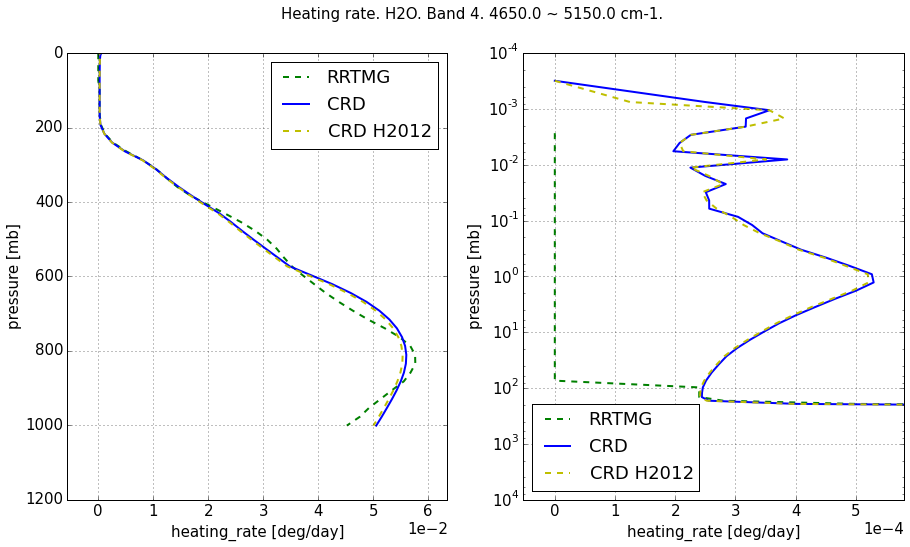


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 5. 5150.0 ~ 6150.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  28.035864  28.035864       0.00000
30   299.70000       -0  26.110076  26.110076       0.19698
0   1013.00000       -0  13.928674  13.928674       0.07250

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  28.035864  28.035864      0.051478
30   299.800000        0  26.271366  26.271366      0.190869
0   1013.000000        0  14.381236  14.381236      0.060883

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  28.035864  28.035864      0.052293
30   299.800000        0  26.267817  26.267817      0.191215
0   1013.000000        0  14.374373  14.374373      0.061013

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     -0.

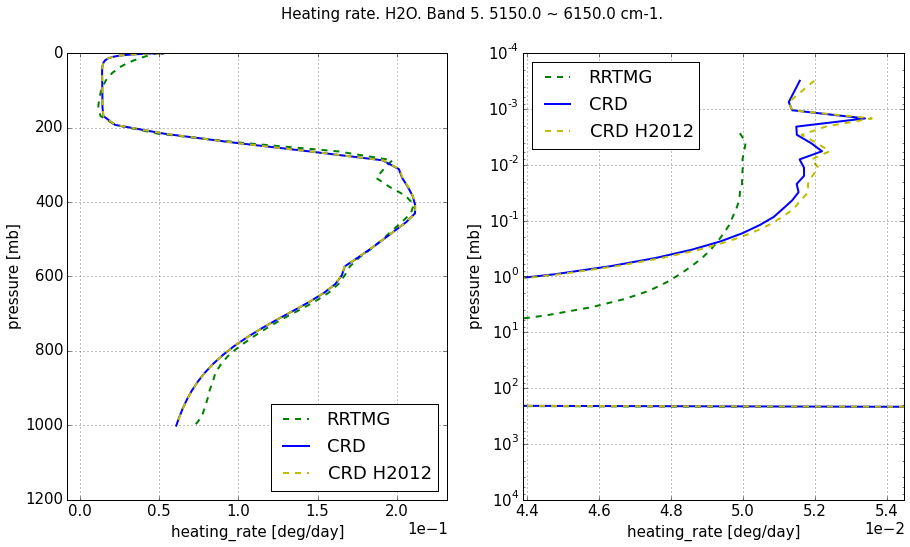


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 6. 6150.0 ~ 7700.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  51.855615  51.855615       0.00000
30   299.70000       -0  48.958738  48.958738       0.32089
0   1013.00000       -0  22.018722  22.018722       0.17859

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  51.855615  51.855615      0.051024
30   299.800000        0  49.114513  49.114513      0.314609
0   1013.000000        0  22.024200  22.024200      0.176723

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  51.855615  51.855615      0.051024
30   299.800000        0  49.113963  49.113963      0.314643
0   1013.000000        0  21.995314  21.995314      0.177889

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     -0.

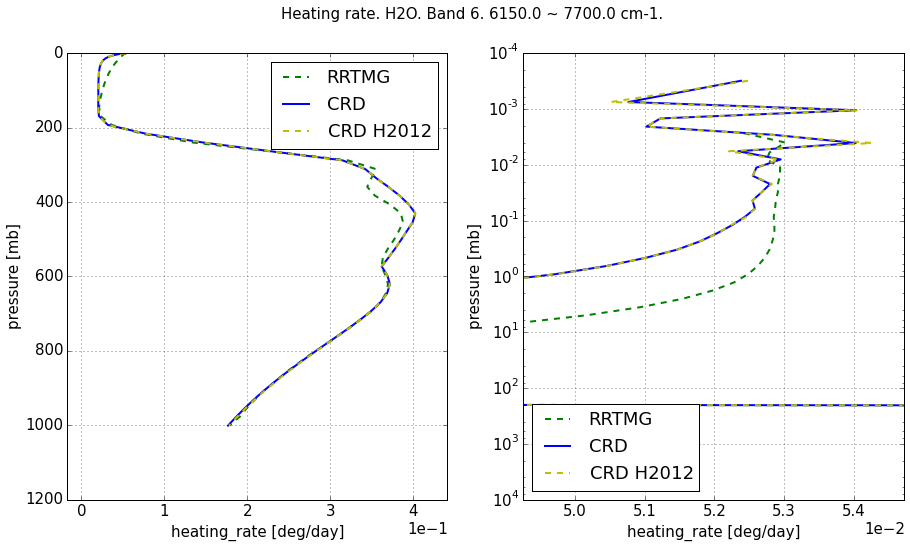


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 7. 7700.0 ~ 8050.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  12.480128  12.480128       0.00000
30   299.70000       -0  12.479511  12.479511       0.00011
0   1013.00000       -0  12.091858  12.091858       0.01195

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  12.480128  12.480128      0.000000
30   299.800000        0  12.479374  12.479374      0.000127
0   1013.000000        0  12.131535  12.131535      0.010220

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  12.480128  12.480128      0.000000
30   299.800000        0  12.479366  12.479366      0.000129
0   1013.000000        0  12.111669  12.111669      0.010985

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000      0.

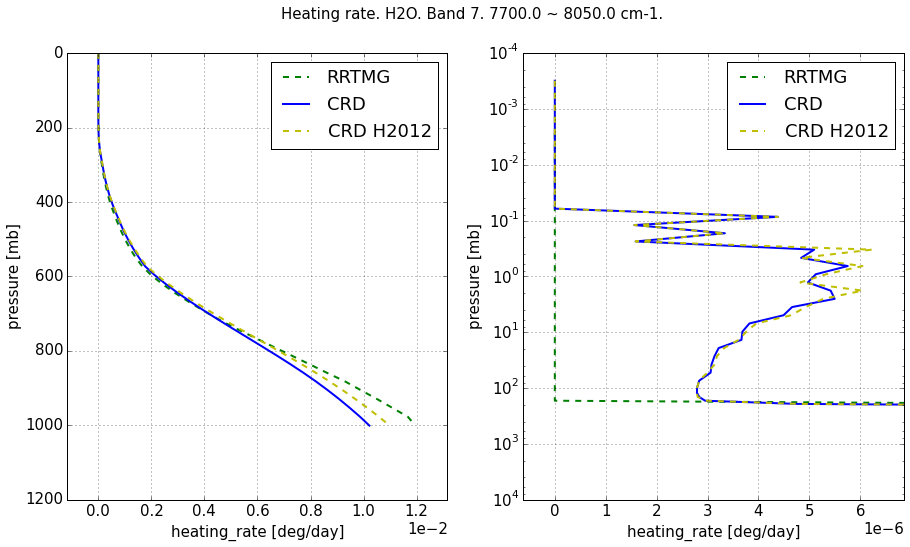


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 8. 8050.0 ~ 12850.0 cm-1.

RRTMG
      pressure   flux_up   flux_down    net_flux  heating_rate
70     0.00242 -0.000102  175.812141  175.812039       0.00000
30   299.70000 -0.000000  174.917781  174.917781       0.12220
0   1013.00000 -0.000000  134.984917  134.984917       0.62027

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  175.812141  175.812141      0.006344
30   299.800000        0  174.987310  174.987310      0.115099
0   1013.000000        0  134.939120  134.939120      0.644188

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  175.812141  175.812141      0.005528
30   299.800000        0  174.926855  174.926855      0.121961
0   1013.000000        0  134.369180  134.369180      0.640213

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  heating_rate
70  0.000003 -0.0001

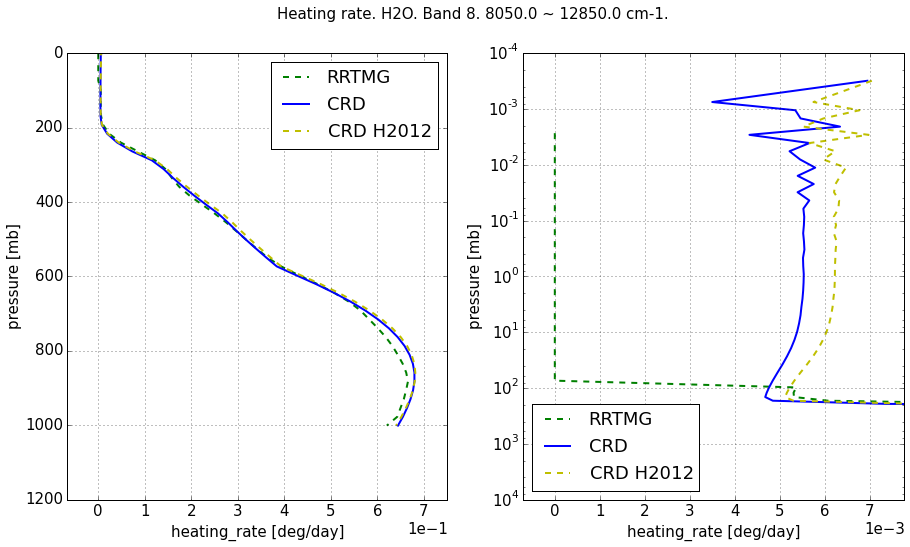


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 9. 12850.0 ~ 16000.0 cm-1.

RRTMG
      pressure  flux_up   flux_down    net_flux  heating_rate
70     0.00242       -0  108.653756  108.653756       0.00000
30   299.70000       -0  108.625172  108.625172       0.00455
0   1013.00000       -0  102.938691  102.938691       0.14624

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  108.653756  108.653756      0.000181
30   299.800000        0  108.622366  108.622366      0.004965
0   1013.000000        0  103.098143  103.098143      0.136598

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  108.653756  108.653756      0.000091
30   299.800000        0  108.622684  108.622684      0.004914
0   1013.000000        0  103.191861  103.191861      0.134081

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   

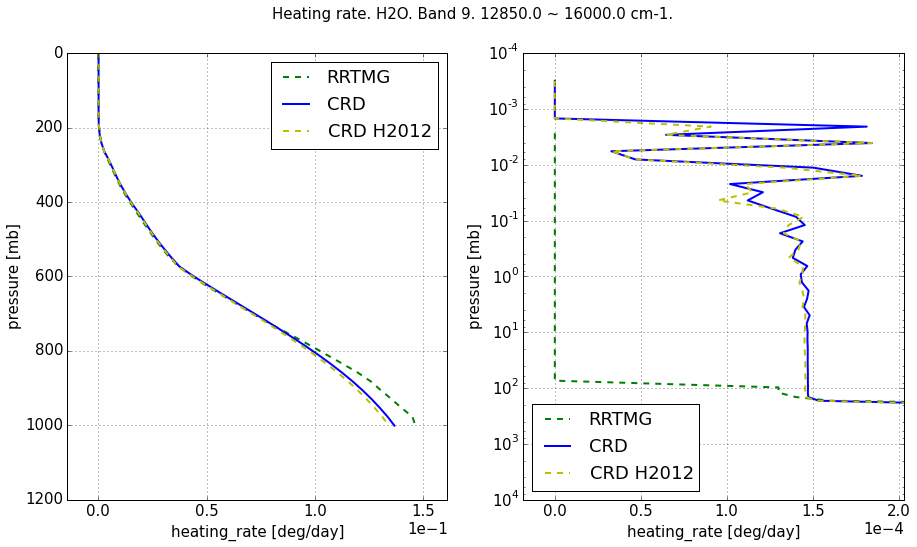


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 10. 16000.0 ~ 22650.0 cm-1.

RRTMG
      pressure   flux_up   flux_down    net_flux  heating_rate
70     0.00242 -0.000099  171.966629  171.966530       0.00000
30   299.70000 -0.000099  171.963459  171.963360       0.00050
0   1013.00000 -0.000000  170.843175  170.843175       0.03616

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  171.966629  171.966629      0.000000
30   299.800000        0  171.963221  171.963221      0.000544
0   1013.000000        0  170.861801  170.861801      0.034325

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  171.966629  171.966629      0.000000
30   299.800000        0  171.963107  171.963107      0.000563
0   1013.000000        0  170.816163  170.816163      0.035807

RRTMG - CRD
    pressure   flux_up  flux_down  net_flux  heating_rate
70  0.000003 -0.00

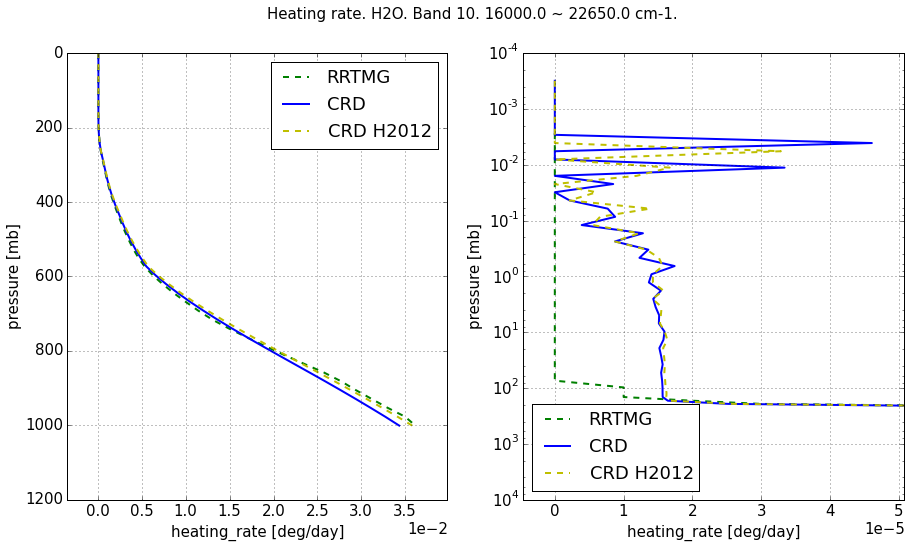


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 11. 22650.0 ~ 29000.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  63.770652  63.770652             0
30   299.70000       -0  63.770652  63.770652             0
0   1013.00000       -0  63.770652  63.770652             0

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  63.770652  63.770652      0.000000
30   299.800000        0  63.770644  63.770644      0.000001
0   1013.000000        0  63.767486  63.767486      0.000106

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  35.084367  35.084367      0.000000
30   299.800000        0  35.084354  35.084354      0.000002
0   1013.000000        0  35.079264  35.079264      0.000173

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


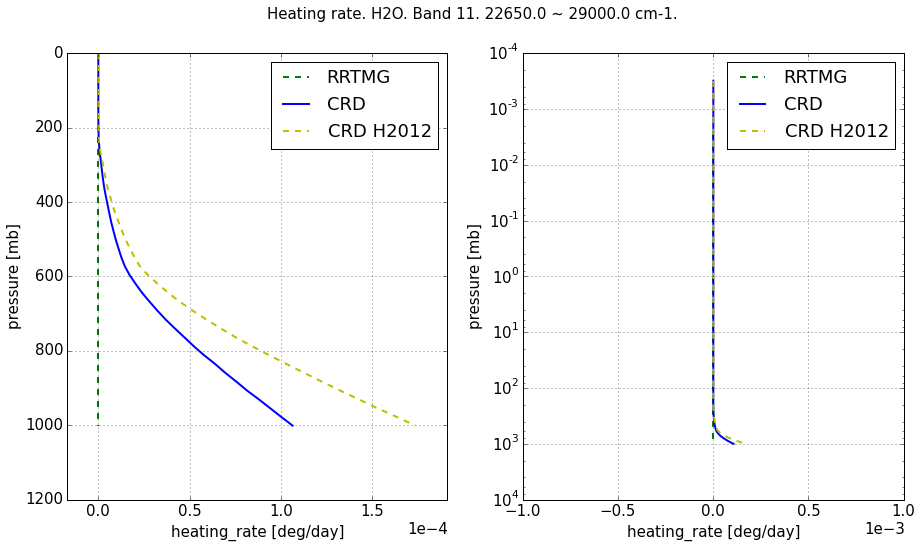


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 12. 29000.0 ~ 38000.0 cm-1.

RRTMG
      pressure  flux_up  flux_down   net_flux  heating_rate
70     0.00242       -0  23.027947  23.027947             0
30   299.70000       -0  23.027947  23.027947             0
0   1013.00000       -0  23.027947  23.027947             0

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  23.027947  23.027947             0
30   299.800000        0  23.027947  23.027947             0
0   1013.000000        0  23.027947  23.027947             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0          0         0         

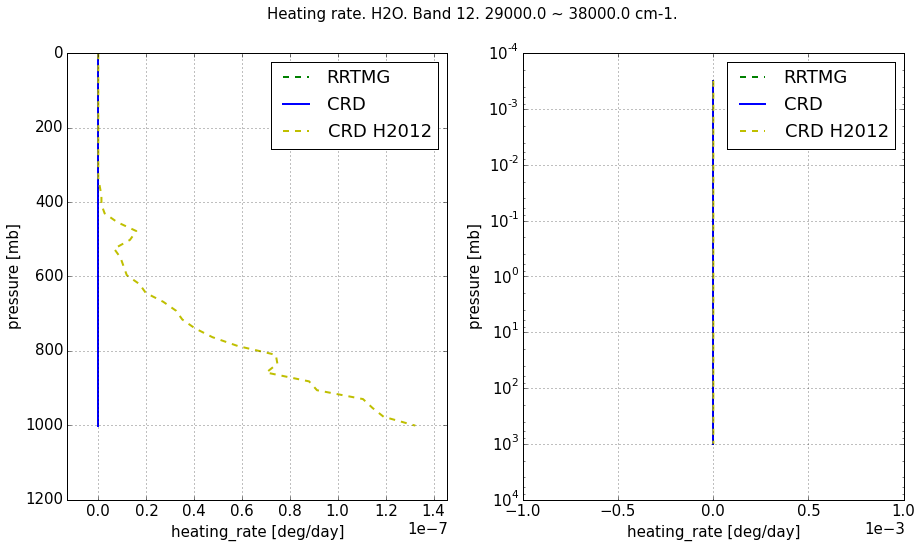


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 13. 38000.0 ~ 50000.0 cm-1.

RRTMG
      pressure  flux_up  flux_down  net_flux  heating_rate
70     0.00242       -0   1.544536  1.544536             0
30   299.70000       -0   1.544536  1.544536             0
0   1013.00000       -0   1.544536  1.544536             0

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   1.544536  1.544536             0
30   299.800000        0   1.544536  1.544536             0
0   1013.000000        0   1.544536  1.544536             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0          0         0             0
30

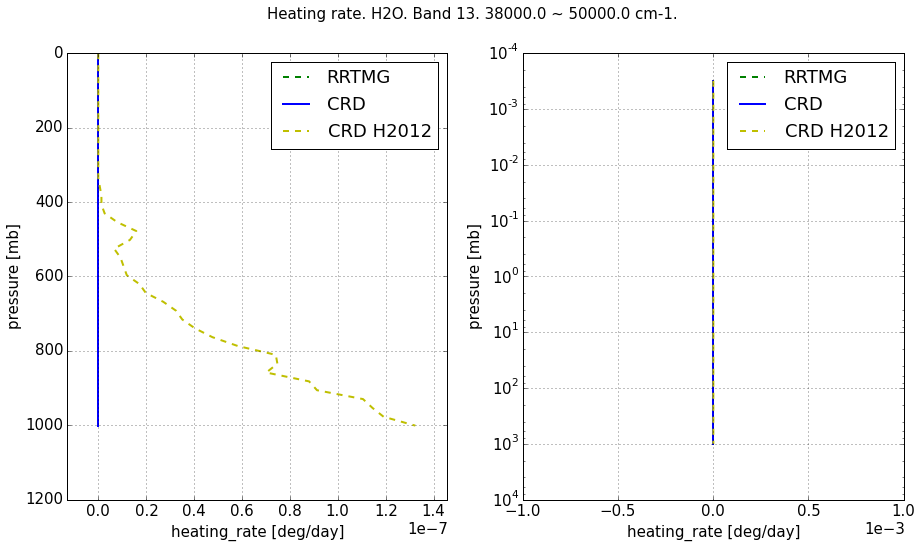


------------------------------------------------------------------------

RRTMG-SW spectral band. Band 14. 820.0 ~ 2600.0 cm-1.

RRTMG
      pressure  flux_up  flux_down  net_flux  heating_rate
70     0.00242       -0   6.190728  6.190728       0.00000
30   299.70000       -0   4.531497  4.531497       0.06512
0   1013.00000       -0   1.793810  1.793810       0.02083

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.190728  6.190728      0.075472
30   299.800000        0   5.527706  5.527706      0.059484
0   1013.000000        0   3.251453  3.251453      0.017368

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.190728  6.190728      0.076435
30   299.800000        0   5.521796  5.521796      0.059959
0   1013.000000        0   3.239135  3.239135      0.017324

RRTMG - CRD
    pressure  flux_up  flux_down  net_flux  heating_rate
70  0.000003       -0   0.000000  0.000000     -0.075472
30 -0

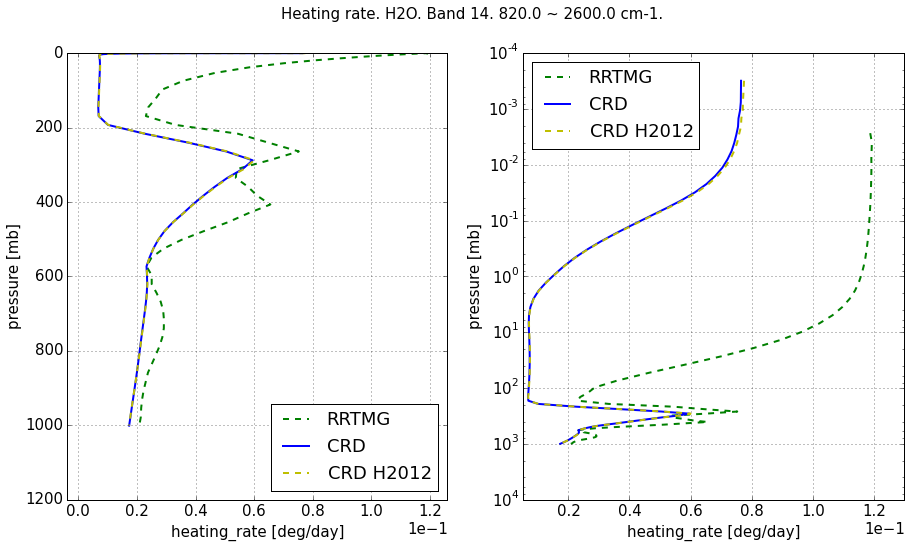


------------------------------------------------------------------------



In [103]:
print('Flux tables and heating rates in RRTMG spectral bands')
print()
print()

scripts_intermodel.sw_results_by_rrtmg_bands(
    infos_rrtmg=[('RRTMG', 'g', '--', pnl_rrtmg)],
    infos_lbl=[('CRD', 'b', '-', pnl_crd),
               ('CRD H2012', 'y', '--', pnl_crd_H2012)],
    name_molecule=name_molecule) 

In [104]:
html_download = ('<a href='
                 '"./shortwave_mls_{name_molecule}_by_rrtmg_bands.xlsx"'
                 'download>'
                 'shortwave_mls_{name_molecule}_by_rrtmg_bands.xlsx'
                 '</a>')

display.HTML(html_download.format(name_molecule=name_molecule))

# In CLIRAD's wavenumber bands

Flux tables and heating rates in CLIRAD spectral bands


CLIRAD-SW spectral. Band 1. 35088 ~ 44444 cm-1

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -4.817481e-12   3.514538  3.514538      0.170928
30   299.800000 -2.064617e-12   2.147952  2.147952     -0.019623
0   1013.000000 -0.000000e+00   2.701359  2.701359     -0.001352

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   3.514606  3.514606             0
30   299.800000        0   3.514606  3.514606             0
0   1013.000000        0   3.514606  3.514606             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

CLIRAD - CRD
    pressure       flux_up  flux_down  net_flux  heating_rate
70         0 -4.817481e-12  -0.000069 -0.000069      0.1

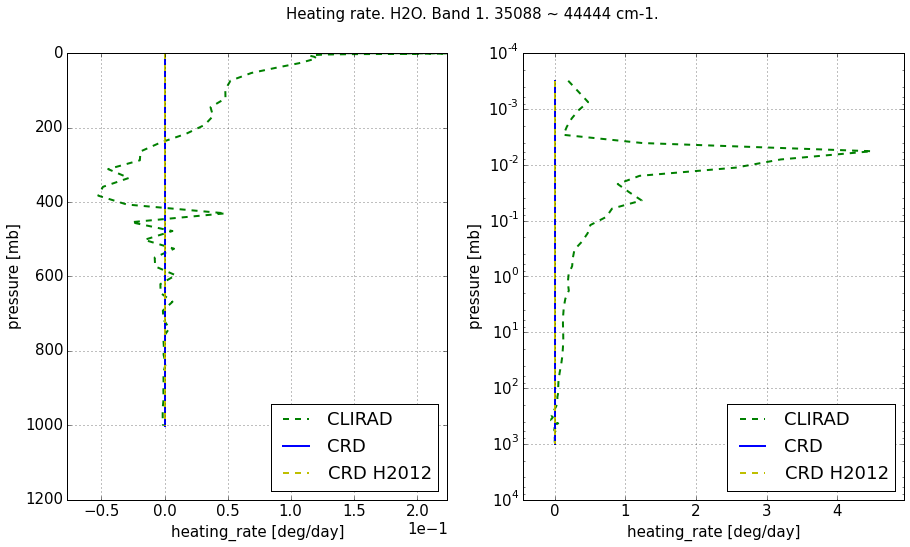


------------------------------------------------------------------------

CLIRAD-SW spectral. Band 2. 33333 ~ 35088 44444 ~ 57142 cm-1

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -7.473721e-13   3.854356  3.854356  2.327879e-02
30   299.800000 -3.203125e-13   3.854270  3.854270  6.795004e-07
0   1013.000000 -0.000000e+00   3.854206  3.854206  6.794891e-07

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   3.854367  3.854367             0
30   299.800000        0   3.854367  3.854367             0
0   1013.000000        0   3.854367  3.854367             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.053610  0.053610  0.000000e+00
30   299.800000        0   0.053610  0.053610  0.000000e+00
0   1013.000000        0   0.053603  0.053603  2.645502e-07

CLIRAD - CRD
    pressure       flux_up  flux_down  net_flux  heating_rate
70         0 -7.473721e-

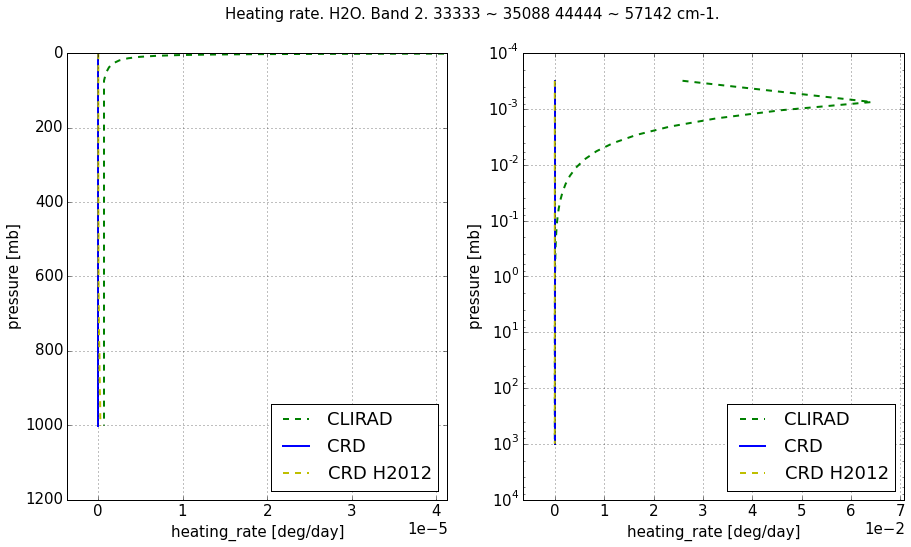


------------------------------------------------------------------------

CLIRAD-SW spectral. Band 3. 30770 ~ 33333 cm-1

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -1.662077e-13   7.937312  7.937312  5.518143e-03
30   299.800000 -7.125401e-14   7.937293  7.937293  1.610760e-07
0   1013.000000 -0.000000e+00   7.937279  7.937279  1.610757e-07

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   7.937315  7.937315             0
30   299.800000        0   7.937315  7.937315             0
0   1013.000000        0   7.937315  7.937315             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

CLIRAD - CRD
    pressure       flux_up  flux_down  net_flux  heating_rate
70         0 -1.662077e-13  -0.000002 

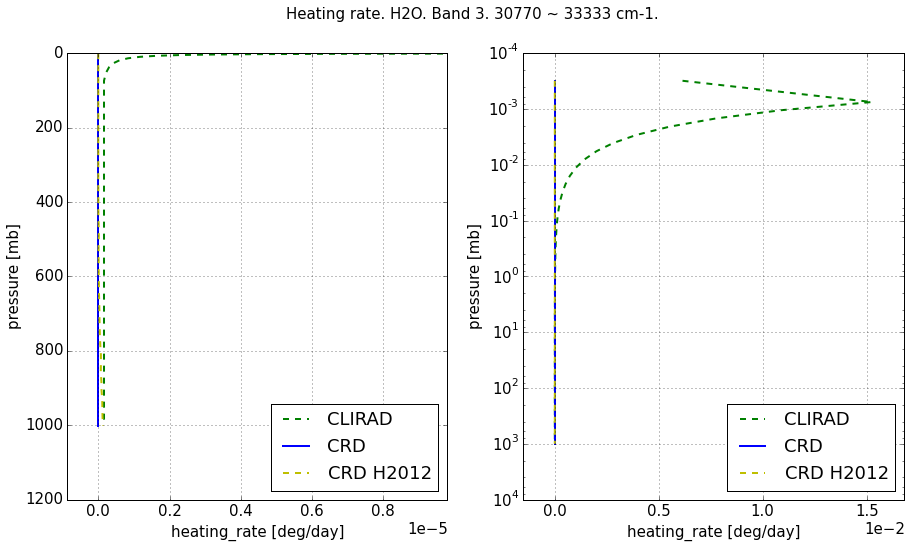


------------------------------------------------------------------------

CLIRAD-SW spectral. Band 4. 25000 ~ 30770 cm-1

CLIRAD
       pressure       flux_up  flux_down   net_flux  heating_rate
70     0.002417 -2.755213e-13  37.994446  37.994446  1.006937e-02
30   299.800000 -1.181866e-13  37.994418  37.994418  2.939280e-07
0   1013.000000 -0.000000e+00  37.994389  37.994389  2.939279e-07

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  37.994446  37.994446  0.000000e+00
30   299.800000        0  37.994442  37.994442  6.372359e-07
0   1013.000000        0  37.993089  37.993089  4.518218e-05

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

CLIRAD - CRD
    pressure       flux_up  flux_down      net_flux  heating_rate
70         0 -2.755213e-13

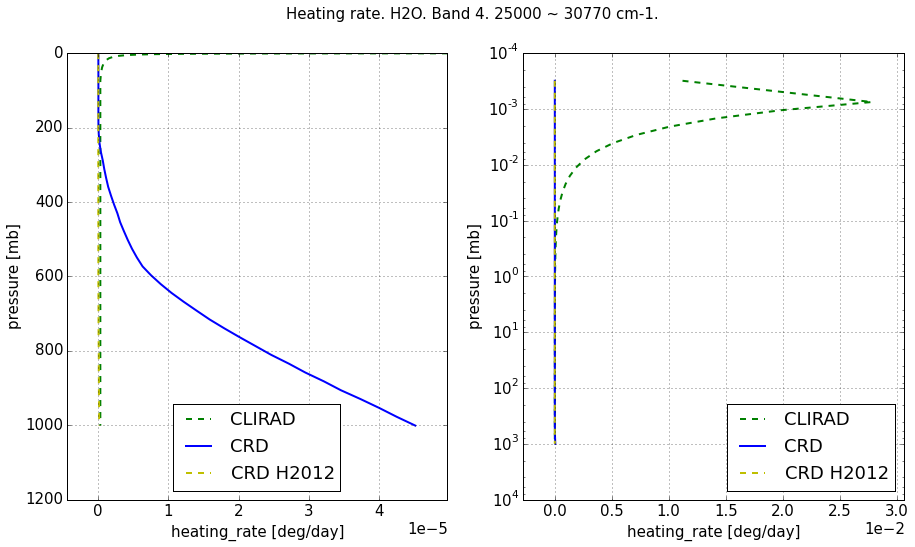


------------------------------------------------------------------------

CLIRAD-SW spectral. Band 5. 14286 ~ 25000 cm-1

CLIRAD
       pressure       flux_up   flux_down    net_flux  heating_rate
70     0.002417 -1.313133e-08  265.032088  265.032088      0.068761
30   299.800000 -1.311769e-08  265.029312  265.029312      0.000462
0   1013.000000 -0.000000e+00  262.394723  262.394723      0.105804

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.032088  265.032088      0.000000
30   299.800000        0  265.023960  265.023960      0.001294
0   1013.000000        0  262.667273  262.667273      0.070186

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.032088  265.032088      0.000000
30   299.800000        0  265.023806  265.023806      0.001320
0   1013.000000        0  262.601527  262.601527      0.072326

CLIRAD - CRD
    pressure       flux_up  flux_down      net_flux  heating_rat

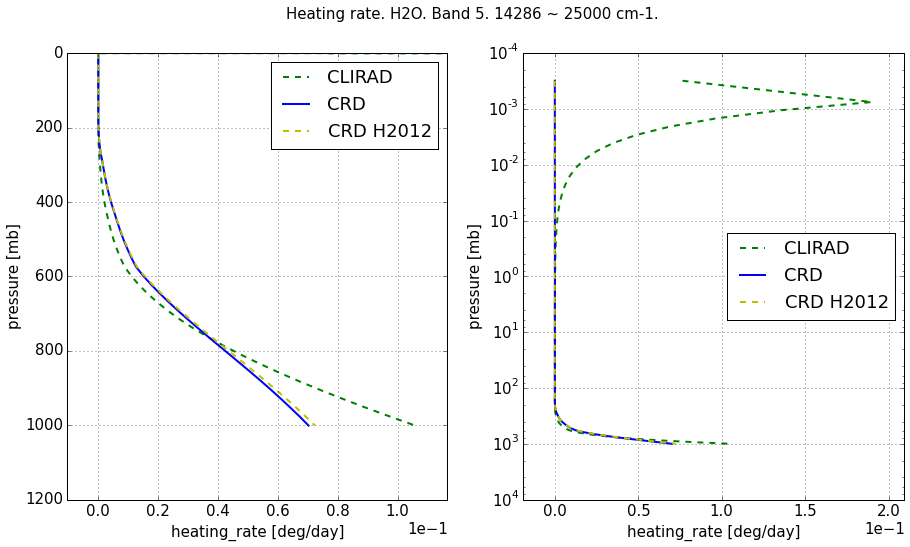


------------------------------------------------------------------------

CLIRAD-SW spectral. Band 6. 8200 ~ 14280 cm-1

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000147  220.865316  220.865168      0.482215
30   299.800000 -0.000059  220.058063  220.058004      0.124549
0   1013.000000 -0.000000  175.214582  175.214582      0.705824

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865516  220.865516      0.006525
30   299.800000        0  220.015121  220.015121      0.119135
0   1013.000000        0  176.023065  176.023065      0.735980

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865516  220.865516      0.005619
30   299.800000        0  219.955098  219.955098      0.125926
0   1013.000000        0  175.592757  175.592757      0.728109

CLIRAD - CRD
    pressure   flux_up  flux_down  net_flux  heating_rate
70         0 -0.000147 

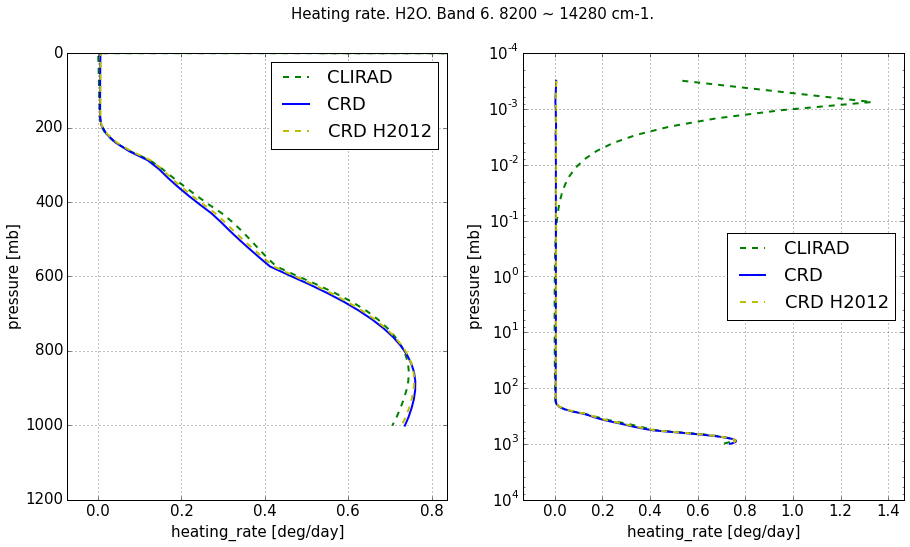


------------------------------------------------------------------------

CLIRAD-SW spectral. Band 7. 4400 ~ 8200 cm-1

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000070  113.874410  113.874340      0.275648
30   299.800000 -0.000025  109.372959  109.372934      0.526873
0   1013.000000 -0.000000   68.443046   68.443046      0.293032

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874481  113.874481      0.102819
30   299.800000        0  109.311992  109.311992      0.514139
0   1013.000000        0   65.973001   65.973001      0.315031

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874481  113.874481      0.103635
30   299.800000        0  109.308523  109.308523      0.514424
0   1013.000000        0   65.936687   65.936687      0.317339

CLIRAD - CRD
    pressure   flux_up  flux_down  net_flux  heating_rate
70         0 -0.000070  

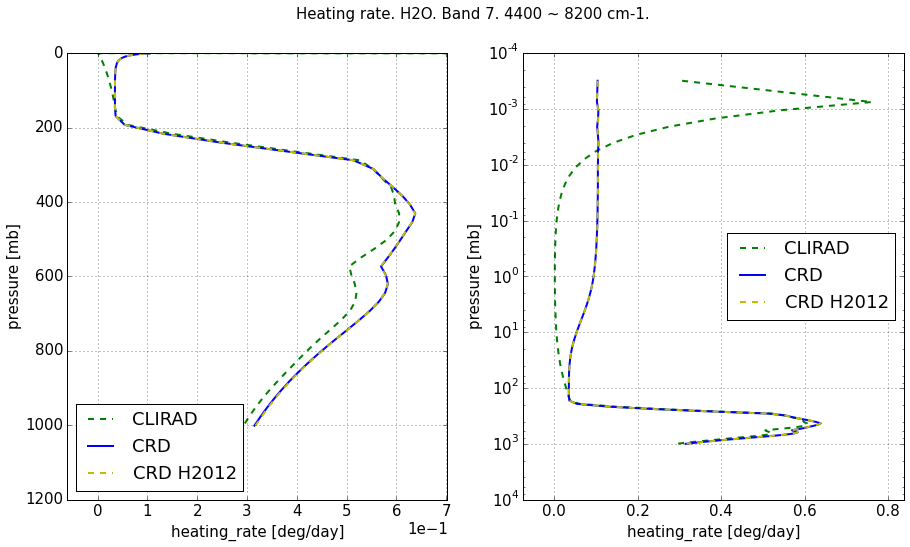


------------------------------------------------------------------------

CLIRAD-SW spectral. Band 8. 1000 ~ 4400 cm-1

CLIRAD
       pressure   flux_up  flux_down   net_flux  heating_rate
70     0.002417 -0.000016  29.352214  29.352197      0.099339
30   299.800000 -0.000005  25.551348  25.551343      0.358429
0   1013.000000 -0.000000  11.293426  11.293426      0.097072

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352152  29.352152      0.351427
30   299.800000        0  25.503385  25.503385      0.355014
0   1013.000000        0  10.547735  10.547735      0.100243

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352152  29.352152      0.352367
30   299.800000        0  25.499421  25.499421      0.355324
0   1013.000000        0  10.532794  10.532794      0.100384

CLIRAD - CRD
    pressure   flux_up  flux_down  net_flux  heating_rate
70         0 -0.000016   0.000061  0.000045     

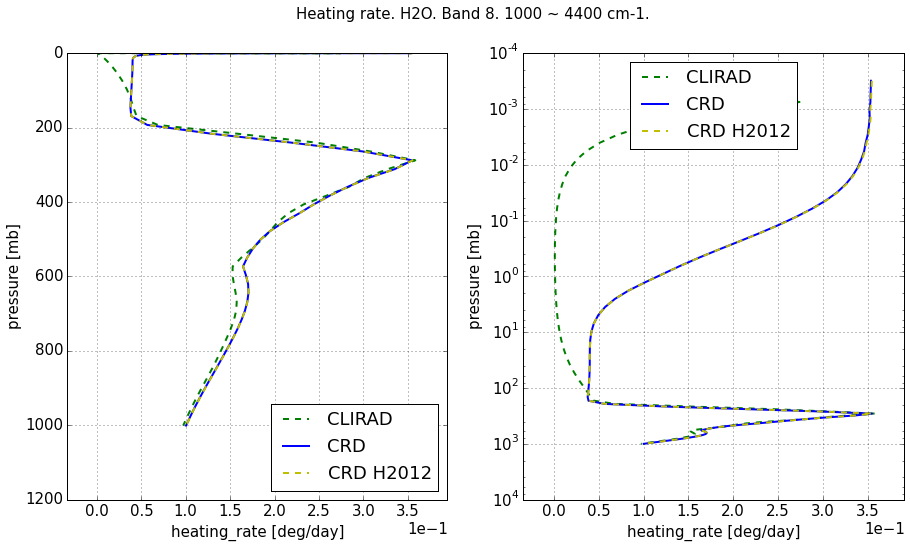


------------------------------------------------------------------------



In [107]:
print('Flux tables and heating rates in CLIRAD spectral bands')
print()
print()

scripts_intermodel.sw_results_by_clirad_bands(
    infos_clirad=[('CLIRAD', 'g', '--', pnl_clirad)],
    infos_lbl=[('CRD', 'b', '-', pnl_crd),
               ('CRD H2012', 'y', '--', pnl_crd_H2012)],
    name_molecule=name_molecule)

In [108]:
html_download = ('<a href='
                 '"./shortwave_mls_{name_molecule}_by_clirad_bands.xlsx"'
                 'download>'
                 'shortwave_mls_{name_molecule}_by_clirad_bands.xlsx'
                 '</a>')
display.HTML(html_download.format(name_molecule=name_molecule))

In [111]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')